In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

# Recursive OLS residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import chow_test

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

In [42]:
inf1 = pd.read_csv('data/inflation.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date, format='%d/%m/%Y')
inf1 = inf1.drop("date", axis = 1)
inf1['v_cpi'] = inf1['CPI'].pct_change(12)*100
inf1['vol_cpi1'] = inf1['CPI'].rolling(12).std()
# inf1.head()

In [150]:

from fredapi import Fred
fred = Fred(api_key='ca6ea25f72db47e2d070a76b7e9e639b')
CorePCE = fred.get_series('PCEPILFE')
PCE = fred.get_series('PCEPI')
CpiUS = fred.get_series('CPIAUCSL')
inf1['pce'] = PCE.pct_change(12)*100
inf1['core_pce'] = CorePCE.pct_change(12)*100
inf1['cpiUS'] = CpiUS.pct_change(12)*100


In [151]:
simdf = inf1.loc['1993-01-01':'2021-12-01']
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

In [45]:
simdf.tail()

,CPI,target,v_cpi,vol_cpi1,pce,core_pce
date,,,,,,
2021-08-01,151.33,4.0,3.615200,1.429622,4.237068,3.599161
2021-09-01,151.65,4.0,3.671042,1.191707,4.436350,3.702763
2021-10-01,152.20,4.0,2.956098,1.193511,5.058376,4.186197
2021-11-01,152.94,4.0,2.885974,1.325007,5.649879,4.686596
2021-12-01,153.20,4.0,3.067815,1.380425,5.782392,4.889339


Text(0.5, 1.0, 'CPI inflation')

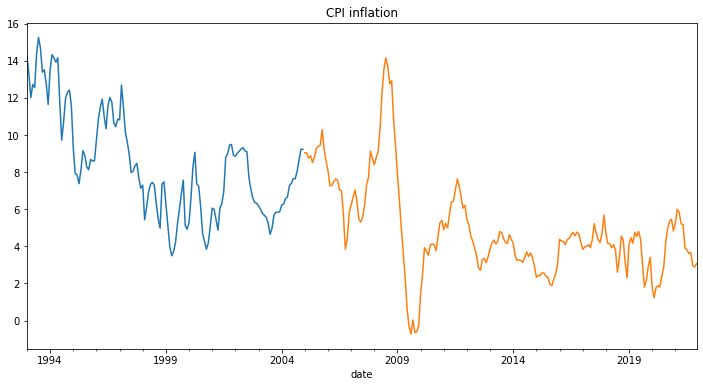

In [46]:
predf['v_cpi'].plot(figsize=(12,6))
itdf['v_cpi'].plot(figsize=(12,6))
plt.title('CPI inflation')

Text(0.5, 1.0, 'Core PCE and PCE inflation')

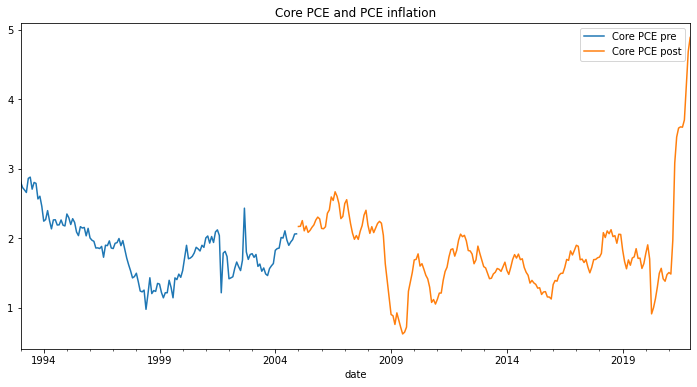

In [47]:
predf['core_pce'].plot(figsize=(12,6), label='Core PCE pre')
itdf['core_pce'].plot(figsize=(12,6), label='Core PCE post')
# predf['pce'].plot(figsize=(12,6), label='PCE pre')
# itdf['pce'].plot(figsize=(12,6), label='PCE post')
plt.legend()
plt.title('Core PCE and PCE inflation')

In [48]:
# ADF Test for Stationarity on inflation

# Whole period
adf = adfuller(simdf['pce'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['pce'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['pce'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.016100008164943048 , whole period: Series is Stationary
p value:0.24934158485261249 , Series is Non-Stationary
p value:0.17152570376243248 , Series is Non-Stationary


In [49]:
# ADF Test for Stationarity on inflation

# Whole period
adf = adfuller(simdf['core_pce'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['core_pce'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['core_pce'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.24176676444379852 , Series is Non-Stationary
p value:0.3279423279579085 , Series is Non-Stationary
p value:0.8183898194564008 , Series is Non-Stationary


In [50]:
# ADF Test for Stationarity on CORE PCE and PCE inflation

# Whole period
adf = adfuller(simdf['v_cpi'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['v_cpi'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['v_cpi'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.03841611734408168 , whole period: Series is Stationary
p value:0.15320315266553963 , Series is Non-Stationary
p value:0.19635563540377454 , Series is Non-Stationary


Aditive Decomposition for Inflation

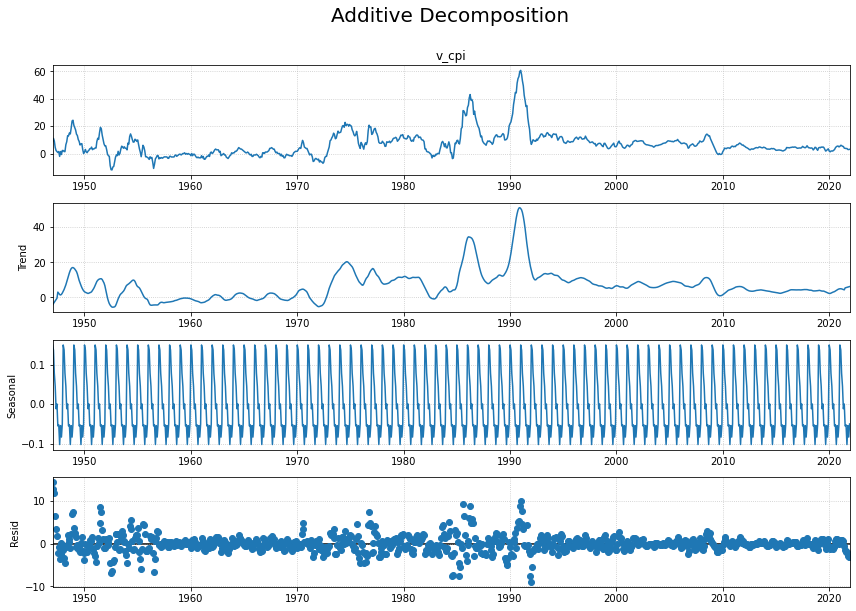

In [51]:
# # Additive Decomposition
plt.rcParams['figure.figsize'] = (12, 8);
a = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq').plot()
plt.suptitle('Additive Decomposition', x = 0.525, y = 1.055, fontsize=20)
for i in range(len(a.axes)):
    a.axes[i].grid(axis='x', alpha=0.75, linestyle=':')
    a.axes[i].grid(axis='y', alpha=0.75, linestyle=':')
plt.show()

In [52]:
decomp = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq')
df_rec = pd.concat([decomp.seasonal, decomp.trend, decomp.resid, decomp.observed], axis=1)
df_rec.columns = ['seas', 'trend', 'resid', 'actual_values']
df_rec.head()

,seas,trend,resid,actual_values
date,,,,
1947-01-01,0.149721,-4.176101,12.687797,8.661417
1947-02-01,0.136805,-3.423370,14.310186,11.023622
1947-03-01,0.078374,-2.670638,11.752570,9.160305
1947-04-01,0.045319,-1.917907,6.350199,4.477612
1947-05-01,-0.011785,-1.165175,3.366741,2.189781


In [53]:
# DataFrame with seasonally adjusted Data
inf1['inf_seasAdj'] = df_rec.resid

# IT regime dummy variable
inf1['IT_reg'] = np.zeros(len(inf1))
inf1['IT_reg']['2005-01-01':] = 1 

# lag creation
inf1["inf_seasAdj_l1"] = inf1['inf_seasAdj'].shift()
inf1["inf_seasAdj_l3"] = inf1['inf_seasAdj'].shift(3)
inf1["inf_seasAdj_l6"] = inf1['inf_seasAdj'].shift(6)
inf1["inf_seasAdj_l12"] = inf1['inf_seasAdj'].shift(12)
inf1["inf_seasAdj_l24"] = inf1['inf_seasAdj'].shift(24)
# drop na's
inf1.dropna(inplace=True)

# Working DataFrames
# complete "simetric" dataframe
simdf = inf1.loc['1993-01-01':'2021-12-01']
# Pre IT DataFrame
predf = simdf.loc['1993-01-01':'2004-12-01']
# IT DataFrame
itdf  = simdf.loc['2005-01-01':'2021-12-01']


In [152]:
# DataFrame with observed data
''' This data is for the models and tests which consider the whole period, since v_cpi is stationary when we consider 
the whole period. '''
inf2 = pd.read_csv('data/inflation.csv', delimiter=';')
inf2.index = pd.to_datetime(inf2.date, format='%d/%m/%Y')
inf2 = inf2.drop("date", axis = 1)
inf2['v_cpi'] = inf2['CPI'].pct_change(12)*100

# IT regime dummy variable
inf2['IT_reg'] = np.zeros(len(inf2))
inf2['IT_reg']['2005-01-01':] = 1 
inf2['pce'] = PCE.pct_change(12)*100
inf2['core_pce'] = CorePCE.pct_change(12)*100
inf2['cpiUS'] = CpiUS.pct_change(12)*100

# lag creation
inf2["l1"] = inf2['v_cpi'].shift()
inf2["l3"] = inf2['v_cpi'].shift(3)
inf2["l6"] = inf2['v_cpi'].shift(6)
inf2["l12"] = inf2['v_cpi'].shift(12)
inf2["l18"] = inf2['v_cpi'].shift(18)
inf2["l24"] = inf2['v_cpi'].shift(24)
# drop na's
inf2.dropna(inplace=True)

# Working DataFrames
# complete "simetric" dataframe
simdf2 = inf2.loc['1993-01-01':'2021-12-01']
# Pre IT DataFrame
predf2 = inf2.loc['1993-01-01':'2004-12-01']
# IT DataFrame
itdf2  = inf2.loc['2005-01-01':'2021-12-01']

# inf2.head(24)

In [155]:
inf1.to_csv('output/inflation_SeasAdj.csv', sep=';')
inf2.to_csv('output/inflationLags.csv', sep=';')

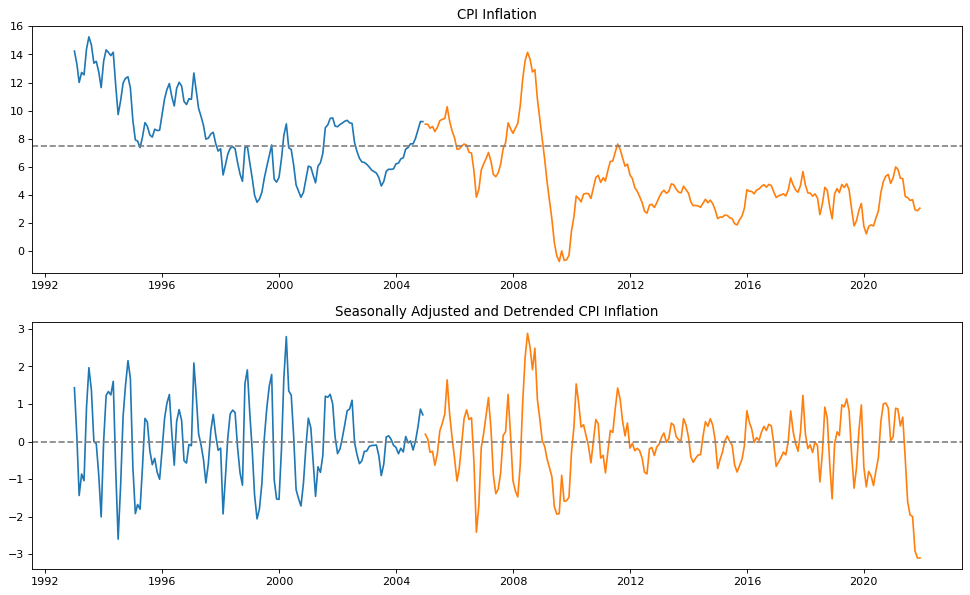

In [56]:
# Ploting the data
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation')
axes[0].axhline(y=np.mean(inf1['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['inf_seasAdj'])
axes[1].plot(itdf['inf_seasAdj'])
axes[1].set_title('Seasonally Adjusted and Detrended CPI Inflation')
axes[1].axhline(y=0, color='grey', linestyle='--')

plt.show()


In [57]:
# ADF Test for Stationarity on Seasonally adjusted inflation
# Whole period
adf = adfuller(simdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:1.870370093513673e-09 , whole period: Series is Stationary
p value:5.359212083582485e-05 , Pre IT period: Series is Stationary
p value:0.003422291791936745 , IT period: Series is Stationary


Benchmark Models

Kontonikas (2004)

$\pi = \gamma_0 + \gamma_1\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + \gamma_4\pi_{t-12} + u_{1t}$

Model 1: Using the seasonally adjusted data

In [119]:
# Whole Period
mod1_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6 + inf_seasAdj_l12', data=simdf).fit() #+ inf_seasAdj_l3 + inf_seasAdj_l6
print(mod1_1.params[1:])
print('Estimated persistence, Complete period: ',mod1_1.params[1:].sum())

inf_seasAdj_l1     0.706229
inf_seasAdj_l3    -0.258603
inf_seasAdj_l6     0.113868
inf_seasAdj_l12   -0.182637
dtype: float64
Estimated persistence, Complete period:  0.37885676433484894


In [59]:
mod1_1.pvalues
# All lags significant

Intercept          3.343030e-01
inf_seasAdj_l1     2.992466e-49
inf_seasAdj_l3     3.100467e-12
inf_seasAdj_l6     2.514321e-03
inf_seasAdj_l12    1.013216e-07
dtype: float64

In [60]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres = recursive_olsresiduals(mod1_1, alpha=0.90)

breaks_cusumolsresid(mod1_1.resid)
# We cannot reject the null hypothesis of no structural change.

(0.729043908894949, 0.6624986464217185, [(1, 1.63), (5, 1.36), (10, 1.22)])

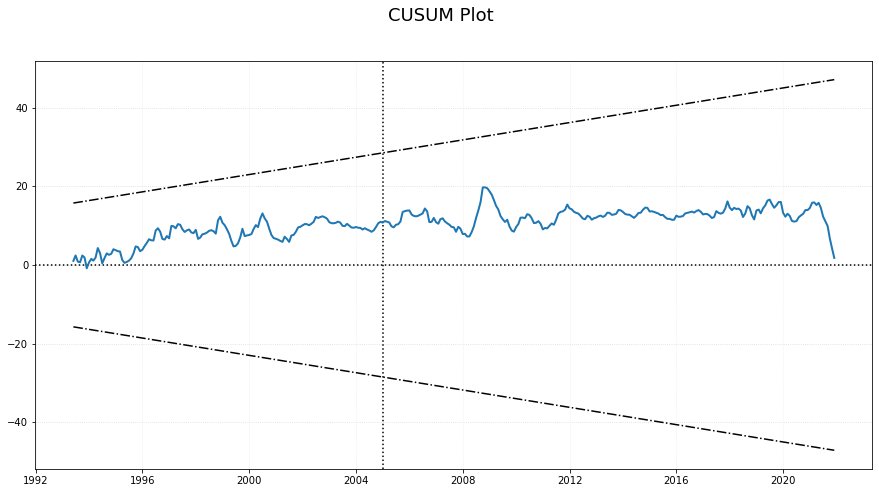

In [61]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres[6][1],index=simdf.index[5:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres[6][0],index=simdf.index[5:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres[5][1:],index=simdf.index[5:]), linewidth=2)
plt.suptitle('CUSUM Plot', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Model 1B: Using the observed inflation

In [118]:
# Whole Period
mod1_1B = smf.ols(formula='v_cpi ~ l1 + l3 + l6 + l12', data=simdf2).fit()
print(mod1_1B.params[1:])
print('Estimated persistence, Complete period: ',mod1_1B.params[1:].sum())

l1     1.090500
l3    -0.179290
l6     0.078489
l12   -0.040986
dtype: float64
Estimated persistence, Complete period:  0.9487128037687321


In [63]:
mod1_1B.pvalues
# All lags significant

Intercept     2.024843e-03
l1           1.183389e-109
l3            1.119583e-05
l6            1.011624e-02
l12           3.113101e-02
dtype: float64

In [64]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres = recursive_olsresiduals(mod1_1B, alpha=0.90)

breaks_cusumolsresid(mod1_1B.resid)
# We reject the null hypothesis of no structural change.

(1.706869759123615, 0.005894936043870829, [(1, 1.63), (5, 1.36), (10, 1.22)])

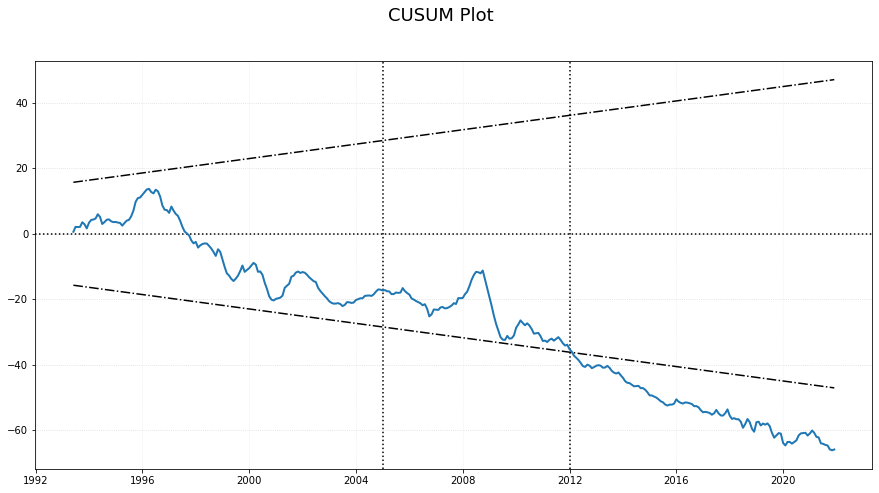

In [65]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres[6][1],index=simdf.index[5:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres[6][0],index=simdf.index[5:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2012-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres[5][1:],index=simdf.index[5:]), linewidth=2)
plt.suptitle('CUSUM Plot', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Some evidence of structural break, but only after 2012. That is more likely to be due to the low inflation in the US after the 2008 recession.

Kontonikas (2004) adding Controls (PCE inflation)

$\pi = \gamma_0 + \gamma_1\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + \gamma_4\pi_{t-12} + \delta X+ u_{1t}$

In [156]:
simdf2.head()

,CPI,target,v_cpi,IT_reg,pce,core_pce,cpiUS,l1,l3,l6,l12,l18,l24
date,,,,,,,,,,,,,
1993-01-01,27.44,7.0,14.238135,0.0,2.704497,2.814311,3.253796,14.219992,11.584327,10.442630,6.660746,34.275822,60.627675
1993-02-01,27.50,7.0,13.308611,0.0,2.598302,2.732447,3.246753,14.238135,13.172385,9.652837,8.155080,34.971429,57.473684
1993-03-01,27.70,7.0,12.009705,0.0,2.560483,2.698032,3.019410,13.308611,14.219992,11.167945,10.057855,26.332795,53.065395
1993-04-01,28.09,7.0,12.720706,0.0,2.555078,2.660260,3.156385,12.009705,14.238135,11.584327,9.442249,21.469219,49.409449
1993-05-01,28.25,7.0,12.549801,0.0,2.737185,2.863213,3.221188,12.720706,13.308611,13.172385,9.035621,17.696909,42.538700


In [157]:
# Whole Period
mod1_1BC = smf.ols(formula='v_cpi ~ l1 + l3 + l6 + l12 + cpiUS', data=simdf2).fit()
# mod1_1BC.summary()
print(mod1_1BC.params[1:5])
print('Estimated persistence, Complete period: ',mod1_1BC.params[1:5].sum())

l1     1.061227
l3    -0.176057
l6     0.085560
l12   -0.037123
dtype: float64
Estimated persistence, Complete period:  0.9336061201166784


In [165]:
# mod1_1BC.summary()

In [166]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres1BC = recursive_olsresiduals(mod1_1BC, alpha=0.90)

breaks_cusumolsresid(mod1_1BC.resid)
# We reject the null hypothesis of no structural change.

(1.4841975774246106, 0.02441544057395054, [(1, 1.63), (5, 1.36), (10, 1.22)])

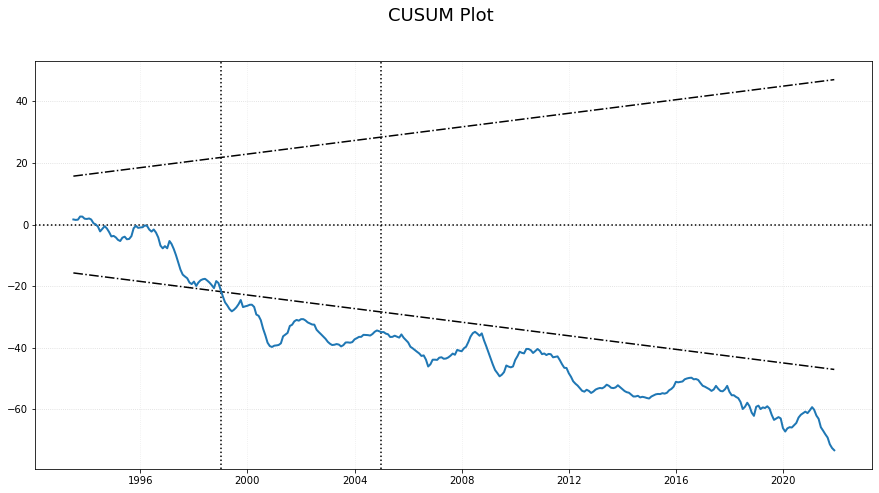

In [162]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres1BC[6][1],index=simdf2.index[6:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres1BC[6][0],index=simdf2.index[6:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('1999-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres1BC[5][1:],index=simdf2.index[6:]), linewidth=2)
plt.suptitle('CUSUM Plot', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Model 2: Seasonally adjusted data for pre IT period

In [172]:
# Pre IT Period
mod1_2 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12 + cpiUS', data=predf).fit()
print(mod1_2.params[1:5])
print('Estimated persistence, pre IT period: ', mod1_2.params[1:5].sum())


inf_seasAdj_l1     0.597377
inf_seasAdj_l3    -0.327156
inf_seasAdj_l6     0.185037
inf_seasAdj_l12   -0.162163
dtype: float64
Estimated persistence, pre IT period:  0.29309460985193914


In [168]:
mod1_2.pvalues[1:]
# All lags significant

inf_seasAdj_l1     4.141398e-16
inf_seasAdj_l3     6.948543e-08
inf_seasAdj_l6     4.014090e-03
inf_seasAdj_l12    3.378917e-04
cpiUS              6.370107e-01
dtype: float64

Model 3: Seasonally adjusted data for IT period


In [173]:
# IT Period
mod1_3 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12 + cpiUS', data=itdf).fit()
print(mod1_3.params[1:])
print('Estimated persistence, IT period: ', mod1_3.params[1:5].sum())

inf_seasAdj_l1     0.737119
inf_seasAdj_l3    -0.168112
inf_seasAdj_l6    -0.079332
inf_seasAdj_l12   -0.308706
cpiUS             -0.012350
dtype: float64
Estimated persistence, IT period:  0.18096898636526315


In [174]:
mod1_3.pvalues[1:]
# All lags significant

inf_seasAdj_l1     2.913802e-32
inf_seasAdj_l3     5.268674e-04
inf_seasAdj_l6     9.854713e-02
inf_seasAdj_l12    1.389444e-08
cpiUS              6.131539e-01
dtype: float64

Persistence have decreased, with the introduction of the IT (lags significant in all models)

Model with whole period and Dummy for IT regime

as in Kontonikas (2004)

$\pi = \gamma_0 + (\gamma_1 + \gamma_5D_t)\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + (\gamma_4 + \gamma_6D_t)\pi_{t-12} + u_{1t}$


Model 2.1 Seasonally adjusted data

In [141]:
# Whole Period
mod2_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l1*target + inf_seasAdj_l12 + inf_seasAdj_l12*target + pce', data=simdf).fit()
mod2_1.params[1:]

inf_seasAdj_l1            0.953919
target                   -0.002715
inf_seasAdj_l1:target    -0.064301
inf_seasAdj_l12          -0.504898
inf_seasAdj_l12:target    0.039877
pce                       0.002809
dtype: float64

In [142]:
mod2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            inf_seasAdj   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     75.73
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           9.45e-60
Time:                        10:36:40   Log-Likelihood:                -329.70
No. Observations:                 348   AIC:                             673.4
Df Residuals:                     341   BIC:                             700.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0237      0.137     -0.173      0.863      -0.294       0.246
inf_seasAdj_l1             0.9539      0.167      5.709      0.000       0.625       1.283
target                    -0.0027      0.022     -0.122      0.903      -0.047       0.041
inf_seasAdj_l1:target     -0.0643      0.028     -2.305      0.022      -0.119      -0.009
inf_seasAdj_l12           -0.5049      0.161     -3.128      0.002      -0.822      -0.187
inf_seasAdj_l12:target     0.0399      0.025      1.585      0.114      -0.010       0.089
pce                        0.0028      0.035      0.080      0.937      -0.067       0.072
==============================================================================
Omnibus:                        9.057   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               15.728
Skew:                           0.065   Prob(JB):                     0.000384
Kurtosis:                       4.033   Cond. No.                         45.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
mod2_1.params[3] + mod2_1.params[5]

# The sum is negative, means that IT has diminished the inflation 
# The interaction term with the 1st lag is negative and significant, means that IT has decreased the inflation persistance


-0.024424270177955454

In [144]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
# recres2 = recursive_olsresiduals(mod2_1, alpha=0.90)

breaks_cusumolsresid(mod2_1.resid)
# We cannot reject the null hypothesis of no structural change.

(0.6003375007903784, 0.8638355709011905, [(1, 1.63), (5, 1.36), (10, 1.22)])

Model 2.1B Observed data

In [146]:
# Whole Period
mod2_1B = smf.ols(formula='v_cpi ~ l1 + l1*target + l12 + l12*target + pce', data=simdf2).fit()
mod2_1B.params[1:]

l1            0.974241
target        0.278586
l1:target    -0.006395
l12          -0.017963
l12:target   -0.009205
pce           0.146310
dtype: float64

In [147]:
mod2_1B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  v_cpi   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1085.
Date:                Thu, 07 Jul 2022   Prob (F-statistic):          9.60e-219
Time:                        10:37:03   Log-Likelihood:                -378.15
No. Observations:                 348   AIC:                             770.3
Df Residuals:                     341   BIC:                             797.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9349      0.506     -1.848      0.065      -1.930       0.060
l1             0.9742      0.069     14.214      0.000       0.839       1.109
target         0.2786      0.107      2.595      0.010       0.067       0.490
l1:target     -0.0064      0.012     -0.553      0.580      -0.029       0.016
l12           -0.0180      0.061     -0.292      0.770      -0.139       0.103
l12:target    -0.0092      0.011     -0.864      0.388      -0.030       0.012
pce            0.1463      0.044      3.322      0.001       0.060       0.233
==============================================================================
Omnibus:                        8.156   Durbin-Watson:                   1.318
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               12.441
Skew:                           0.124   Prob(JB):                      0.00199
Kurtosis:                       3.893   Cond. No.                         897.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
mod2_1B.params[3] + mod2_1B.params[5] 

# The sum is negative, means that IT has diminished the inflation 
# The interaction term with the 1st lag is negative and significant, means that IT has decreased the inflation persistance

-0.01560010713055885

In [149]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
# recres2 = recursive_olsresiduals(mod2_1B, alpha=0.90)

breaks_cusumolsresid(mod2_1B.resid)
# We cannot reject the null hypothesis of no structural change.

(1.0498411156874905, 0.22035195040970995, [(1, 1.63), (5, 1.36), (10, 1.22)])

Chow Test

Perfom Chow Test to check structural break in 2005 due to the IT introduction

Test for seasonally adjusted data

In [78]:
# Chow test for inflation persistance using inflation lagged 1 period (one month) (SHORT RUN)
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l1'],
                    len(predf)-1, len(predf), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance 

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 1.8067814504302555, P_value: 0.16574076007097582


(1.8067814504302555, 0.16574076007097582)

In [79]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l12'],
                    len(predf)-1, len(predf), 0.05)

# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.1536513493873057, P_value: 0.04393665669678393


(3.1536513493873057, 0.04393665669678393)

Tests for observed data

We can observe more evidence when using the observed data (which is stationary considering the longer period)

In [80]:
# Chow test for inflation persistance using inflation lagged 1 period (one month) (SHORT RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l1'],
                    len(predf2)-1, len(predf2), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance 

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.6299949420644463, P_value: 0.5332096227065113


(0.6299949420644463, 0.5332096227065113)

In [81]:
# Chow test for inflation persistance using inflation lagged 3 periods (one quarter) 
chow_test.chow_test(simdf2['v_cpi'], simdf2['l3'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance                    

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.790284618264656, P_value: 0.02354109765226342


(3.790284618264656, 0.02354109765226342)

In [82]:
# Chow test for inflation persistance using inflation lagged 6 periods (two quarters) 
chow_test.chow_test(simdf2['v_cpi'], simdf2['l6'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance    

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 11.239919003142624, P_value: 1.8700982123642795e-05


(11.239919003142624, 1.8700982123642795e-05)

In [83]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l12'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 34.3325482472182, P_value: 2.5646151868841116e-14


(34.3325482472182, 2.5646151868841116e-14)

In [84]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l24'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 36.93981770062148, P_value: 2.9976021664879227e-15


(36.93981770062148, 2.9976021664879227e-15)